In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, generate_binary_structure
from scipy.optimize import fsolve, minimize
from finesse.gaussian import HGMode
import scipy
import scipy.integrate as integrate

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
from matplotlib import cm
from IPython.display import HTML
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import matplotlib as mpl
import matplotlib.gridspec as gridspec

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
from IPython.display import IFrame

import finesse
from finesse.knm.tools import make_scatter_matrix
# finesse.configure(plotting=True)

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

%config InlineBackend.figure_format='svg'

### EOBD

In [2]:
# def EOBD_func(z, w0):
#     c = 1j*np.pi/(1064e-9)*1e-6
#     zR = np.pi*w0**2/(1064e-9)
#     coeff = c*w0*(1+(z/zR)**2)**0.5*np.exp(-1j*np.arctan(z/zR))

#     return coeff

$$
\cos(\arctan(x)) = \frac{1}{\sqrt{1+x^2}}
$$
$$
\cos(2\arctan(x)) = \frac{2}{1+x^2} - 1 = \frac{1 - x^2}{1+x^2}
$$

In [3]:
k = 2*np.pi/(1064e-9)
Lx = Ly = 1e-3 #2 mm
Lz = 10e-3 #20 mm

R = Lx/2 # 1 mm, we zone in to half of the size to get the activate area
# w0 = R*.38
w0 = R*0.1165 # The beam size 
zR = np.pi*w0**2/(1064e-9)
q_0 = zR*1j 
print(q_0)

def fsolve_func(w0_, w_sol):
    z = Lz
    zR_ = np.pi*w0_**2/(1064e-9)
    w = w0_*(1+(z/zR_)**2)**0.5
    return w-w_sol

# w_lz = 90e-6
w_lz = 85e-6
w0_s = fsolve(fsolve_func, x0=0.8*w0, args=(w_lz))
w0_l = fsolve(fsolve_func, x0=1.2*w0, args=(w_lz))
print(w0_s/w0, w0_l/w0,)

0.010018440059371258j
[0.83322281] [1.19795014]


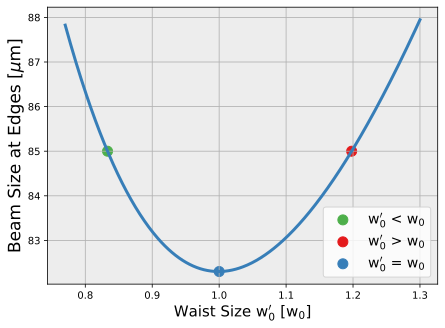

In [4]:
z = Lz
ws = []
# range_ = np.linspace(0.7, 1.425, 400)
range_ = np.linspace(0.77, 1.3, 400)
for w0_ in range_*w0: 
    zR_ = np.pi*w0_**2/(1064e-9)
    w = w0_*(1+(z/zR_)**2)**0.5
    ws.append(w)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,5))
background_color = '#ededed'
ax.patch.set_facecolor(background_color)

ax.plot(range_, np.array(ws)*1e6, lw=3, color=CB_color_cycle[0])

ax.scatter([w0_s/w0], [w_lz*1e6], s=100, color=CB_color_cycle[2], label="w$_{0}^{\prime}$ < w$_{0}$")
ax.scatter([w0_l/w0], [w_lz*1e6], s=100, color=CB_color_cycle[7], label="w$_{0}^{\prime}$ > w$_{0}$")
ax.scatter([1], [np.sqrt(1+(Lz/zR)**2)*w0*1e6], s=100, color=CB_color_cycle[0], label="w$_{0}^{\prime}$ = w$_{0}$")

ax.set_xlabel(r'Waist Size w$_{0}^{\prime}$ [w$_{0}$]', fontsize=15)
# ax.set_ylabel(r"Beam Size at $L_{z}$ [$\mu$m]", fontsize=17)
ax.set_ylabel(r"Beam Size at Edges [$\mu$m]", fontsize=17)

ax.grid();
legend = ax.legend(fontsize=14, ncols=1, loc="best");
# fig.savefig('./Beamsize_Lz.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);

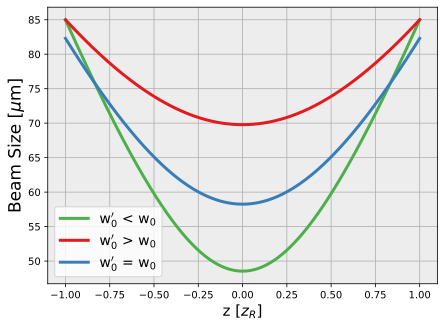

In [5]:
ws_s = []
ws_l = []
ws_0 = []
zs = np.linspace(-1, 1, 400)
for z in zs*Lz:
    zR_s = np.pi*w0_s**2/(1064e-9)
    w_s = w0_s*(1+(z/zR_s)**2)**0.5
    ws_s.append(w_s)

    zR_l = np.pi*w0_l**2/(1064e-9)
    w_l = w0_l*(1+(z/zR_l)**2)**0.5
    ws_l.append(w_l)

    zR_0 = np.pi*w0**2/(1064e-9)
    w_0 = w0*(1+(z/zR_0)**2)**0.5
    ws_0.append(w_0)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,5))
background_color = '#ededed'
ax.patch.set_facecolor(background_color)

ax.plot(zs, np.array(ws_s)*1e6, lw=3, color=CB_color_cycle[2], label="w$_{0}^{\prime}$ < w$_{0}$")
ax.plot(zs, np.array(ws_l)*1e6, lw=3, color=CB_color_cycle[7], label="w$_{0}^{\prime}$ > w$_{0}$")
ax.plot(zs, np.array(ws_0)*1e6, lw=3, color=CB_color_cycle[0], label="w$_{0}^{\prime}$ = w$_{0}$")

ax.set_xlabel(r'z [$z_{R}$]', fontsize=15)
ax.set_ylabel(r"Beam Size [$\mu$m]", fontsize=17)
ax.grid();

legend = ax.legend(fontsize=14, ncols=1, loc="best");

# fig.savefig('./Beamprofile_ws.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);

In [9]:
def gouyPhase_Z_HG10(z, zR, zend):
    return np.arctan(zend/zR) - np.arctan(z/zR)

k = 2*np.pi/(1064e-9)
# voltage = 1 # 1 V
# phi_factor = 1/2*ne**3*r33*k*voltage
Lx = Ly = 1e-3 #2 mm
Lz = 10e-3 #20 mm
# deltaz = 2*Lz/Nz
# deltax = 2*Lx/N
# phi_factor # w

lenz = 200
zlim = Lz
print(zlim)
shape = 400

0.01


In [10]:
def HG10_segments(w0, num=1, amplitude=1e-6, zend=Lz, extra_gouy=True):
    points = [] # the center of each z slice from [-1, 1]
    step = 2/num
    point = -1+step/2
    points.append(point)
    for i in range(num-1):
        points.append(point+step)
        point = point+step

    rho_10s = []
    gouy_phases = []
    x = y = np.linspace(-R, R, shape)
    xx, yy = np.meshgrid(x, y)

    # zstart = zend - 2*Lz # the front of the crystal, defaults to -Lz
    zR = np.pi*w0**2/(1064e-9)

    for i in range(num):
        field_point = zend - Lz + points[i]*Lz # the coordinates of the z location, defaults to [-Lz, Lz]

        q_0 = zR*1j + field_point # the beam parameter at the z location, from [-Lz, Lz]

        HG_10 = HGMode(q_0, n=1, m=0)
        HG_10_data = HG_10.unm(x, y)

        Beam_0 = HGMode(q_0, n=0, m=0)
        Beam_0_data = Beam_0.unm(x, y)

        phi_data = k*yy/num*amplitude 
        # a linear map from EOBD, devided by num so the total phase shifts along the crystal for different number of z slices is fixed

        Beam_0_data_new = Beam_0_data*np.exp(1j*phi_data)

        if extra_gouy:
            gouy = gouyPhase_Z_HG10(field_point, zR, zend) # For the 1st order modes
        else:
            gouy = 0
        gouy_phases.append(gouy)

        rho_10 = np.sum(np.conj(HG_10_data)*Beam_0_data_new)/np.sum(np.conj(HG_10_data)*HG_10_data)
        rho_10s.append(rho_10*np.exp(1j*gouy))

    return np.array(gouy_phases), np.array(rho_10s)
    # return np.array(rho_10s)

In [11]:
Gouy_10_0, HG10_0 = HG10_segments(w0=w0, num=51, extra_gouy=False)
Gouy_10_s, HG10_s = HG10_segments(w0=w0_s[0], num=51, extra_gouy=False)
Gouy_10_l, HG10_l = HG10_segments(w0=w0_l[0], num=51, extra_gouy=False)

(27.819700148749465-64.19514007527835j)
-17.352152072253222
(2.916985687351546e-17-3.442632049248605e-17j)
(91.61581886179528-37.36904046914497j)
1.0
(2.916985687351546e-17-3.442632049248605e-17j)
(30.062415140511014-63.9363499883379j)
-17.694781326954946
(6.004992579879269e-18-8.06870163553187e-18j)
(92.89583785462312-36.790958360864856j)
1.0
(6.004992579879269e-18-8.06870163553187e-18j)
(32.39475860694024-63.56482963349278j)
-18.043253898912344
(1.0339008146573796e-18-1.8513777409388683e-18j)
(94.19469854880583-36.154870603742665j)
1.0
(1.0339008146573796e-18-1.8513777409388683e-18j)
(34.81493125366302-63.068259168607526j)
-18.396953450015783
(1.2665170532212587e-19-4.040057601078764e-19j)
(95.51008580191224-35.45691774002951j)
1.0
(1.2665170532212587e-19-4.040057601078764e-19j)
(37.319859371526064-62.4335881142014j)
-18.755131192089433
(1.2117557032224007e-21-8.02225487969225e-20j)
(96.83921600999831-34.69316790403189j)
1.0
(1.2117557032224007e-21-8.02225487969225e-20j)
(39.90498223

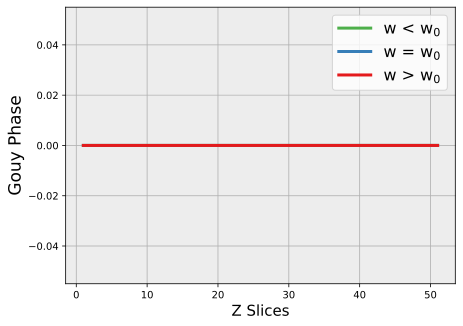

In [12]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,5))
background_color = '#ededed'
ax.patch.set_facecolor(background_color)

ax.plot(range(1, 52), Gouy_10_s, lw=3, label="w < w$_{0}$", color=CB_color_cycle[2])
ax.plot(range(1, 52), Gouy_10_0, lw=3, label="w = w$_{0}$", color=CB_color_cycle[0])
ax.plot(range(1, 52), Gouy_10_l, lw=3, label="w > w$_{0}$", color=CB_color_cycle[7])

ax.set_xlabel(r'Z Slices', fontsize=15)
ax.set_ylabel(r"Gouy Phase", fontsize=17)
ax.grid();
legend = ax.legend(fontsize=16, ncols=1, loc="best");

In [13]:
def phase_norm(phase):
    shape = phase.shape[0]
    length = shape//2
    # print(length)
    return phase-phase[length]

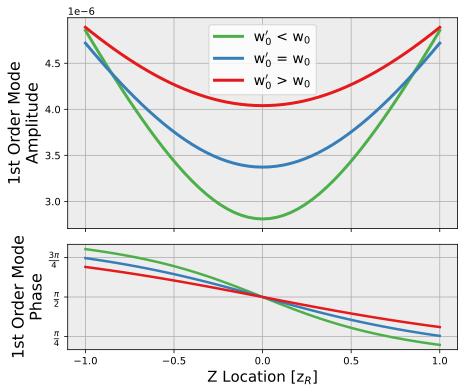

In [14]:
z_vals = np.linspace(-1, 1, 51)
fig, (ax, ax1) = plt.subplots(ncols=1, nrows=2, figsize=(7, 6,), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
background_color = '#ededed'

ax.patch.set_facecolor(background_color)
ax1.patch.set_facecolor(background_color)

plt.subplots_adjust(hspace=0.1) 

ax.plot(z_vals, np.abs(HG10_s), lw=3, color=CB_color_cycle[2], label="w$_{0}^{\prime}$ < w$_{0}$")
ax.plot(z_vals, np.abs(HG10_0), lw=3, color=CB_color_cycle[0], label="w$_{0}^{\prime}$ = w$_{0}$")
ax.plot(z_vals, np.abs(HG10_l), lw=3, color=CB_color_cycle[7], label="w$_{0}^{\prime}$ > w$_{0}$")

ax1.plot(z_vals, np.unwrap(np.angle(HG10_s)), lw=2.5, color=CB_color_cycle[2], label="w$_{0}^{\prime}$ < w$_{0}$")
ax1.plot(z_vals, np.unwrap(np.angle(HG10_0)), lw=2.5, color=CB_color_cycle[0], label="w$_{0}^{\prime}$ = w$_{0}$")
ax1.plot(z_vals, np.unwrap(np.angle(HG10_l)), lw=2.5, color=CB_color_cycle[7], label="w$_{0}^{\prime}$ > w$_{0}$")

ax1.set_xlabel('Z Location [z$_{R}$]', fontsize=15)
ax.set_ylabel('1st Order Mode\nAmplitude', fontsize=16)
ax1.set_ylabel('1st Order Mode\nPhase', fontsize=16)

ax.ticklabel_format(axis='y',style='sci',scilimits=(1,4))
# ax1.ticklabel_format(axis='y',style='sci',scilimits=(1,4))
ax.grid()
ax1.grid()
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
# ax1.set_xticks(range(0, 52, 10))

ax1.set_yticks([np.pi/4, 2*np.pi/4, 3*np.pi/4, ])
ax1.set_yticklabels([r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$"])

ax1.tick_params(axis='y', labelsize=12)  # Adjust the fontsize as needed for x-axis

legend = ax.legend(fontsize=14, ncols=1, loc="best");
# legend = ax1.legend(fontsize=14, ncols=1, loc="best");

# fig.savefig('./HG10amp_phase.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);

In [15]:
results_10_0 = []
results_10_0_abs = []
results_10_s = []
results_10_s_abs = []
results_10_l = []
results_10_l_abs = []

steps = range(1, 21)
for step in steps:
    _, HG10_0_ = HG10_segments(w0=w0, num=step, extra_gouy=False)
    _, HG10_s_ = HG10_segments(w0=w0_s[0], num=step, extra_gouy=False)
    _, HG10_l_ = HG10_segments(w0=w0_l[0], num=step, extra_gouy=False)

    results_10_0.append(HG10_0_.sum())
    results_10_0_abs.append(np.abs(HG10_0_).sum())

    results_10_l.append(HG10_l_.sum())
    results_10_l_abs.append(np.abs(HG10_l_).sum())

    results_10_s.append(HG10_s_.sum())
    results_10_s_abs.append(np.abs(HG10_s_).sum())

results_10_0 = np.array(results_10_0)
results_10_0_abs = np.array(results_10_0_abs)
results_10_l = np.array(results_10_l)
results_10_l_abs = np.array(results_10_l_abs)
results_10_s = np.array(results_10_s)
results_10_s_abs = np.array(results_10_s_abs)

(82.75744385449151+0j)
-24.278344418422236
(1.0029764341779306e-32+0j)
(117.03669948635184+0j)
1.0
(1.0029764341779306e-32+0j)
(90.662249846958+0j)
-29.137877717008504
(8.121457550047682e-47+0j)
(128.21578332882606+0j)
1.0
(8.121457550047682e-47+0j)
(75.61147253030067+0j)
-20.266573311226292
(5.041521474810098e-23+0j)
(106.93076992335195+0j)
1.0
(5.041521474810098e-23+0j)
(60.156178469711094-50.092279080019765j)
-21.723202307196132
(-9.517813844611306e-27-2.2151325944107744e-26j)
(107.75467974769238-25.39554007090398j)
1.0
(-9.517813844611306e-27-2.2151325944107744e-26j)
(60.156178469711094+50.092279080019765j)
-21.723202307196132
(-9.517813844611306e-27+2.2151325944107744e-26j)
(107.75467974769238+25.39554007090398j)
1.0
(-9.517813844611306e-27+2.2151325944107744e-26j)
(48.517845799733436-65.72769913648203j)
-23.659110304214543
(4.0976247308403355e-31+1.3505479675126589e-32j)
(109.96952624018711-35.42494725689828j)
1.0
(4.0976247308403355e-31+1.3505479675126589e-32j)
(48.5178457997334

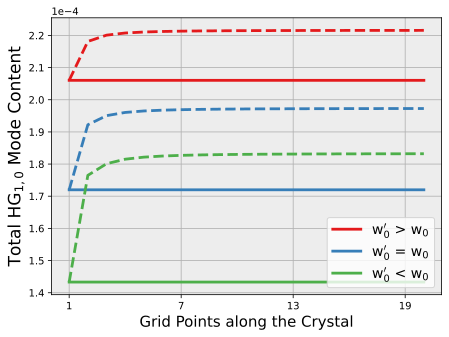

In [16]:
steps = range(1, 21)

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(7, 5))
background_color = '#ededed'
ax1.patch.set_facecolor(background_color)

ax1.plot(steps, np.abs(results_10_l), lw=2.8, color=CB_color_cycle[7], label="w$_{0}^{\prime}$ > w$_{0}$")
ax1.plot(steps, np.abs(results_10_0), lw=2.8, color=CB_color_cycle[0], label="w$_{0}^{\prime}$ = w$_{0}$")
ax1.plot(steps, np.abs(results_10_s), lw=2.8, color=CB_color_cycle[2], label="w$_{0}^{\prime}$ < w$_{0}$")

ax1.plot(steps, np.abs(results_10_l_abs), lw=2.8, color=CB_color_cycle[7], ls="--",)
ax1.plot(steps, np.abs(results_10_0_abs), lw=2.8, color=CB_color_cycle[0], ls="--",)
ax1.plot(steps, np.abs(results_10_s_abs), lw=2.8, color=CB_color_cycle[2], ls="--",)

ax1.set_xlabel('Grid Points along the Crystal', fontsize=15)
ax1.set_ylabel(r'Total $\mathrm{HG}_{1,0}$ Mode Content', fontsize=17)
# ax2.set_ylabel(r'$\mathrm{HG}_{1,0}$ AMP SUM', fontsize=17)

ax1.ticklabel_format(axis='y',style='sci',scilimits=(1,4))
# ax2.ticklabel_format(axis='y',style='sci',scilimits=(1,4))

ax1.set_xticks(range(1, 21, 6))

ax1.grid()
legend = ax1.legend(fontsize=14, ncols=1, loc="best");
# fig.savefig('./EOBD_Convergence.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);

In [27]:
np.abs(results_10_0).mean()/np.abs(results_10_s).mean(), np.abs(results_10_l).mean()/np.abs(results_10_s).mean(),

(1.2001591709030348, 1.4377308510327012)

In [ ]:
# (1.2001591712694746, 1.437730852154869)

In [17]:
step_0 = 20
results_10 = []
results_10_abs = []

results_10_0 = []
results_10_abs_0 = []

w0_evals = 1 + np.linspace(-0.2, 0.2, 100)
for w0_ in w0_evals*w0:
    _, HG10_ = HG10_segments(w0=w0_, num=step_0, extra_gouy=True)
    _, HG10_0 = HG10_segments(w0=w0_, num=step_0, extra_gouy=False)

    results_10.append(np.abs(HG10_.sum()))
    results_10_abs.append(np.abs(HG10_).sum())

    results_10_0.append(np.abs(HG10_0.sum()))
    results_10_abs_0.append(np.abs(HG10_0).sum())

results_10 = np.array(results_10)
results_10_abs = np.array(results_10_abs)

results_10_0 = np.array(results_10_0)
results_10_abs_0 = np.array(results_10_abs_0)

(7.263507890767389-68.82242628560628j)
-16.977572951988254
(-2.250897363129846e-16+5.3709887015267444e-18j)
(86.42082691564933-45.93485048031923j)
1.0
(-2.250897363129846e-16+5.3709887015267444e-18j)
(13.137220412392256-70.58985693709273j)
-18.27582292513773
(2.669330520560496e-19-6.8774126931672085e-19j)
(90.88573097030586-45.28590101918235j)
1.0
(2.669330520560496e-19-6.8774126931672085e-19j)
(20.29699304942834-71.77088791969524j)
-19.72042179385297
(7.352327217406583e-22+2.3837553673066237e-22j)
(95.80159573991968-44.137408317038805j)
1.0
(7.352327217406583e-22+2.3837553673066237e-22j)
(28.936745449468418-71.93545795066518j)
-21.312145856979868
(1.1735858222669625e-25+1.8614169919990932e-25j)
(101.16356029618468-42.308684259365826j)
1.0
(1.1735858222669625e-25+1.8614169919990932e-25j)
(39.1612912725996-70.45775488329261j)
-23.034462694157522
(1.4794007547843338e-29+5.283462692543367e-30j)
(106.91067130967694-39.57160945396685j)
1.0
(1.4794007547843338e-29+5.283462692543367e-30j)
(50

In [18]:
z = Lz
ws_s = []
for w0_ in w0_evals*w0:
    zR_ = np.pi*w0_**2/(1064e-9)
    w_s = w0_*(1+(z/zR_)**2)**0.5
    ws_s.append(w_s*1e6)

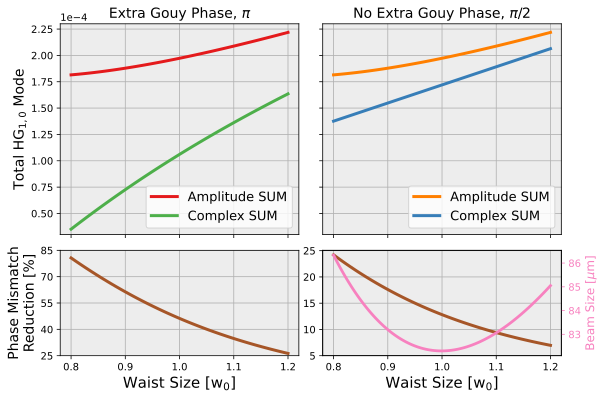

In [22]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(9, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
background_color = '#ededed'
ax1.patch.set_facecolor(background_color)
ax2.patch.set_facecolor(background_color)
ax3.patch.set_facecolor(background_color)
ax4.patch.set_facecolor(background_color)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
plt.subplots_adjust(wspace=0.1, hspace=0.1) 

ax1.plot(w0_evals, results_10_abs, label="Amplitude SUM", lw=3, color=CB_color_cycle[7],)
ax1.plot(w0_evals, results_10, label="Complex SUM", lw=3, color=CB_color_cycle[2],)

ax2.plot(w0_evals, results_10_abs_0, label="Amplitude SUM", ls='-', lw=3, color=CB_color_cycle[1],)
ax2.plot(w0_evals, results_10_0, label="Complex SUM", ls='-', lw=3, color=CB_color_cycle[0],)

ax3.plot(w0_evals, (1-results_10/results_10_abs)*100, lw=3, color=CB_color_cycle[4],)
ax4.plot(w0_evals, (1-results_10_0/results_10_abs_0)*100, lw=3, color=CB_color_cycle[4],)

ax4_y = ax4.twinx()

ax4_y.plot(w0_evals, ws_s, color=CB_color_cycle[3], lw=2.8,)
ax4_y.set_ylabel('Beam Size [$\mu$m]', color=CB_color_cycle[3], fontsize=12)
ax4_y.tick_params('y', colors=CB_color_cycle[3])

ax1.set_ylabel(r'Total HG$_{1,0}$ Mode', fontsize=14)
ax3.set_xlabel('Waist Size [w$_{0}$]', fontsize=15)
ax3.set_ylabel('Phase Mismatch\nReduction [%]', fontsize=14)

xlabel = ax4.set_xlabel('Waist Size [w$_{0}$]', fontsize=15)
# xlabel.set_position((1, 0))

ax1.set_ylim([0.3e-4, 2.3e-4])
ax2.set_ylim([0.3e-4, 2.3e-4])
ax3.set_ylim([25, 85])
ax3.set_yticks([25, 40, 55, 70, 85])
ax4.set_yticks([5, 10, 15, 20, 25])
ax2.set_yticklabels([])

ax1.ticklabel_format(axis='y', style='sci', scilimits=(1,4))

ax1.set_title("Extra Gouy Phase, $\pi$", fontsize=14)
ax2.set_title("No Extra Gouy Phase, $\pi/2$", fontsize=14)
legend = ax1.legend(fontsize=13, ncols=1, loc="best")
legend = ax2.legend(fontsize=13, ncols=1, loc="lower right");

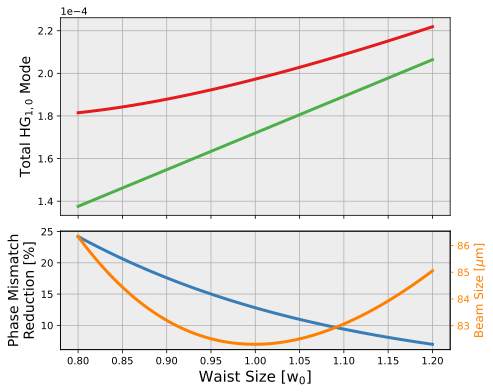

In [23]:
fig, (ax, ax1) = plt.subplots(ncols=1, nrows=2, figsize=(7, 6,), sharex=True, gridspec_kw={'height_ratios': [5, 3]})
background_color = '#ededed'

ax.patch.set_facecolor(background_color)
ax1.patch.set_facecolor(background_color)

ax.plot(w0_evals, results_10_abs_0, label="Amplitude SUM", ls='-', lw=3, color=CB_color_cycle[7],)
ax.plot(w0_evals, results_10_0, label="Complex SUM", ls='-', lw=3, color=CB_color_cycle[2],)

ax1.plot(w0_evals, (1-results_10_0/results_10_abs_0)*100, lw=3, color=CB_color_cycle[0],)

ax1_y = ax1.twinx()

ax1_y.plot(w0_evals, ws_s, color=CB_color_cycle[1], lw=3,)
ax1_y.set_ylabel('Beam Size [$\mu$m]', color=CB_color_cycle[1], fontsize=12)
ax1_y.tick_params('y', colors=CB_color_cycle[1])

ax.grid()
ax1.grid()
plt.subplots_adjust(hspace=0.1)

ax.ticklabel_format(axis='y', style='sci', scilimits=(1,4))

ax1_y.set_ylabel('Beam Size [$\mu$m]', color=CB_color_cycle[1], fontsize=12)
ax1_y.tick_params('y', colors=CB_color_cycle[1])

ax.set_ylabel(r'Total HG$_{1,0}$ Mode', fontsize=14)
ax1.set_xlabel('Waist Size [w$_{0}$]', fontsize=15)
ax1.set_ylabel('Phase Mismatch\nReduction [%]', fontsize=14);
# fig.savefig('./EOBD_waist_size_design.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);

In [21]:
IFrame(src='./illustration_EOBD.pdf', width=880, height=330)

In [29]:
zs = np.linspace(-1, 1, 51)
zR_0 = np.pi*w0**2/(1064e-9)
print(zR_0)
ws_arr = []
for z in zs:
    z = z*zR_0
    w_0 = w0*(1+(z/zR_0)**2)**0.5
    ws_arr.append(w_0*1e6)
ws_arr = np.array(ws_arr)

0.010018440059371258


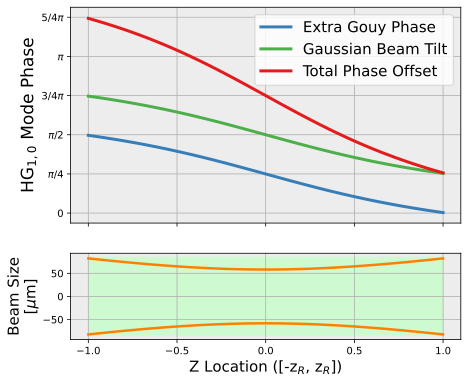

In [234]:
xrange = np.linspace(-1, 1, 51)
fig, (ax, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(7, 6), gridspec_kw={'height_ratios': [2.5, 1]}, sharex=True)
background_color = '#ededed'
ax.patch.set_facecolor(background_color)
ax2.patch.set_facecolor(background_color)

ax.plot(xrange, Gouy_10_0, lw=3, label="Extra Gouy Phase", color=CB_color_cycle[0])
ax.plot(xrange, np.unwrap(np.angle(HG10_0)) - Gouy_10_0 + 2*np.pi, lw=3, color=CB_color_cycle[2], label="Gaussian Beam Tilt")
ax.plot(xrange, np.unwrap(np.angle(HG10_0)) + 2*np.pi, lw=3, color=CB_color_cycle[7], label="Total Phase Offset")

ax2.plot(xrange, ws_arr, color=CB_color_cycle[1], lw=2.5)
ax2.plot(xrange, -ws_arr, color=CB_color_cycle[1], lw=2.5)

ax2.add_patch(Rectangle((-1, -85), 2, 170, color="#cefad0"),)

ax2.set_xlabel(r'Z Location ([-z$_{R}$, z$_{R}$])', fontsize=15)
ax.set_ylabel(r"$\mathrm{HG_{1,0}}$ Mode Phase", fontsize=17)
ax2.set_ylabel("Beam Size\n[$\mu$m]", fontsize=15)
ax.set_xticks([-1, -0.5, 0, 0.5, 1])

ax.set_yticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 5*np.pi/4, 3*np.pi/2])
ax.set_yticklabels([0, "$\pi/4$", "$\pi/2$", "$3/4\pi$", "$\pi$", "$5/4\pi$", "$3/2\pi$"])

ax.set_ylim([-0.2, 5/4*np.pi+0.2])

ax.grid()
ax2.grid()
legend = ax.legend(fontsize=15, ncols=1, loc="best");

In [37]:
def wrap(phase):
    phase = (phase) % (2 * np.pi)
    phase = phase/np.pi

    return phase

wrap(-np.pi), wrap(-2*np.pi), wrap(-3*np.pi)

(1.0, 0.0, 1.0)

In [38]:
w0_ = 1e-3
zR0_ = np.pi*w0_**2/(1064e-9)

def scatter_matrix_10(z):
    z = z*zR0_
    # Non-astigmatic beam with perfect mode matching from input to output
    qx1 = qy1 = qx2 = qy2 = finesse.BeamParam(w0=w0_, z=z)
    
    # angular misalignment along x
    xgamma = -1e-6
    ygamma = 0
    
    # Compute the scattering matrix, returning a KnmMatrix object
    kmat = make_scatter_matrix(
        "bayerhelms",
        qx1, qx2, qy1, qy2,
        xgamma, ygamma,
        maxtem=2,
    )
    return kmat["00->10"]

In [39]:
scatter_matrix_10s = []
z_s = np.linspace(-1, 1, 100)
for z in z_s:
    HG10 = scatter_matrix_10(z)
    scatter_matrix_10s.append(HG10)

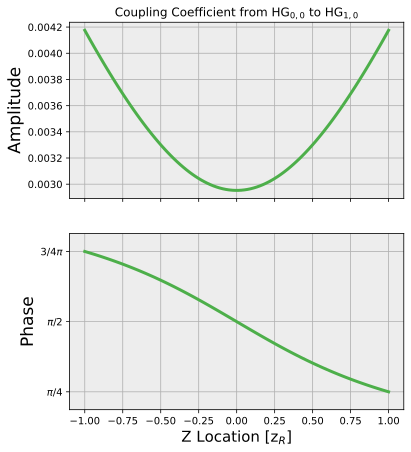

In [40]:
fig, (ax, ax1) = plt.subplots(ncols=1, nrows=2, figsize=(6, 7,), sharex=True)
background_color = '#ededed'

ax.patch.set_facecolor(background_color)
ax1.patch.set_facecolor(background_color)

ax.plot(z_s, np.abs(scatter_matrix_10s), lw=3, color=CB_color_cycle[2])
ax1.plot(z_s, np.angle(scatter_matrix_10s), lw=3, color=CB_color_cycle[2])
ax1.set_xlabel(r'Z Location [z$_{R}$]', fontsize=15)
ax.set_title("Coupling Coefficient from HG$_{0,0}$ to HG$_{1,0}$")
ax.set_ylabel("Amplitude", fontsize=17)
ax1.set_ylabel("Phase", fontsize=17)
ax.grid()
ax1.grid()

ax1.set_yticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
ax1.set_yticklabels([0, "$\pi/4$", "$\pi/2$", "$3/4\pi$", "$\pi$"])
ax1.set_ylim([np.pi/4-0.2, 3*np.pi/4+0.2]);
# legend = ax.legend(fontsize=16, ncols=1, loc="best");

In [11]:
IFrame(src='./illustration_EOBD.pdf', width=880, height=330)

In [3]:
def wrap(phase):
    phase = (phase) % (2 * np.pi)
    phase = phase/np.pi

    return phase

wrap(-np.pi), wrap(-2*np.pi), wrap(-3*np.pi)

(1.0, 0.0, 1.0)

In [4]:
kat = finesse.Model()
kat.modes(maxtem=3)

Ltot = 2
L1 = 0.5
L2 = Ltot - L1
w0 = 5.8e-4
kat.parse(
    f"""
    l L0 P=1

#    tem(L0, 0, 0, 0, phase=0.0)
#    tem(L0, 1, 0, 1, phase=0.0)
    
    gauss input L0.p1.o priority=1 w0={w0} z=-1

    s s0 L0.p1 mirror.p1 L={L1}

    bs mirror R=1 T=0

    s s1 mirror.p2 point.p1 L={L2}
    
    nothing point

    # amplitude detectors
    ad HG20 point.p2.o f=0 n=2 m=0
    ad HG10 point.p2.o f=0 n=1 m=0
    ad HG00 point.p2.o f=0 n=0 m=0
    
    ad HG20_mirror mirror.p2.o f=0 n=2 m=0
    ad HG10_mirror mirror.p2.o f=0 n=1 m=0
    ad HG00_mirror mirror.p2.o f=0 n=0 m=0

#    bp gouyd mirror.p2.o gouy 
    
    noxaxis()
    """
)

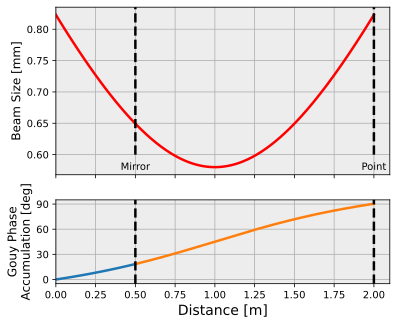

In [5]:
tsy = finesse.tracing.tools.propagate_beam(
    from_node=kat.L0.p1.o, to_node=kat.point.p2.o, direction="x"
)

fig, (ax1, ax2)  = tsy.plot()
background_color = '#ededed'

ax1.patch.set_facecolor(background_color)
ax2.patch.set_facecolor(background_color)
ax1.grid()
ax2.grid()
ax2.set_ylim([-5, 95])
ax2.set_yticks([0, 30, 60, 90])

ax2.set_xlabel('Distance [m]', fontsize=14)
ax1.set_ylabel('Beam Size [mm]', fontsize=12)
ax2.set_ylabel('Gouy Phase\nAccumulation [deg]', fontsize=12)

for line in ax1.get_lines()+ax2.get_lines():
    line.set_linewidth(2.5)

fig.set_size_inches(6, 5);

gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 
ax1.set_subplotspec(gs[0])
ax2.set_subplotspec(gs[1])

text_objects = ax1.texts
for text_object in text_objects:
    # text_properties = text_object.properties()
    # print(text_properties)
    text_object.set_text(text_object.get_text().capitalize())

In [6]:
kat1 = kat.deepcopy()
kat1.mirror.xbeta = 1e-4

L1 = 0.5
L2 = 2 - L1
kat1.s0.L = L1
kat1.s1.L = L2

out1 = kat1.run()

print(r"The phase of the HG10 mode relative to the HG00 mode [pi]:")
print()
# print(f'Gouy phase at the MIRROR {out1["gouyd"]:.3f}')
print("#"*15)
print(f'HG20 mode at the END: {out1["HG20"]}')
print(f'HG10 mode at the END: {out1["HG10"]}')
print(f'HG00 mode at the END: {out1["HG00"]}')
# print(f'Phase Difference at the END: {np.angle(out1["HG10"]) - np.angle(out1["HG00"]):.3f} radians.', end=" "*3)
# print(f'Phase Difference at the END: {np.angle(out1["HG20"]) - np.angle(out1["HG00"]):.3f} radians.', end=" "*3)
print(f'Phase Difference at the END: {np.angle(out1["HG20"]) - np.angle(out1["HG10"]) + 2*np.pi:.3f} radians.', end=" "*3)
print()
print()
print(f'HG20 mode at the MIRROR: {out1["HG20_mirror"]}')
print(f'HG10 mode at the MIRROR: {out1["HG10_mirror"]}')
print(f'HG00 mode at the MIRROR: {np.angle(out1["HG00_mirror"])}')
print(f'Phase Difference at the MIRROR: {np.angle(out1["HG10_mirror"]) - np.angle(out1["HG00_mirror"]):.3f} radians.', end=" "*3)
print(f'Phase Difference at the MIRROR: {np.angle(out1["HG20_mirror"]) - np.angle(out1["HG00_mirror"]):.3f} radians.', end=" "*3)

The phase of the HG10 mode relative to the HG00 mode [pi]:

###############
HG20 mode at the END: (0.0779805941556595-0.05701490180847922j)
HG10 mode at the END: (-0.33867020818811017+0.11060326943980474j)
HG00 mode at the END: (0.9291195038568514+0j)
Phase Difference at the END: 2.826 radians.   

HG20 mode at the MIRROR: (-0.09660058019028768-2.775557561562892e-17j)
HG10 mode at the MIRROR: (-2.775557561562892e-17+0.356273200121693j)
HG00 mode at the MIRROR: 0.0
Phase Difference at the MIRROR: 1.571 radians.   Phase Difference at the MIRROR: -3.142 radians.   

In [7]:
def HG10phase(L): # L in between [-1, 1]
    kat1 = kat.deepcopy()
    kat1.s0.L = Ltot/2 + L
    kat1.s1.L = Ltot/2 - L
    kat1.mirror.xbeta = 1e-4
    out1 = kat1.run()
    phase2 = np.angle(out1["HG20"]) - np.angle(out1["HG10"])
    phase1 = np.angle(out1["HG10"]) - np.angle(out1["HG00"])
    # phase = np.angle(out1["HG10_mirror"]) - np.angle(out1["HG00_mirror"])
    
    return phase1, phase2

In [8]:
L_vals = np.linspace(-1, 1, 100)
zR_0 = np.pi*w0**2/(1064e-9)
L_vals_plot = L_vals/zR_0
phase1s = []
phase2s = []
for L in L_vals:
    phase1, phase2 = HG10phase(L)
    phase1s.append(phase1)
    phase2s.append(phase2)

phase1s = np.array(phase1s)
phase2s = np.array(phase2s)

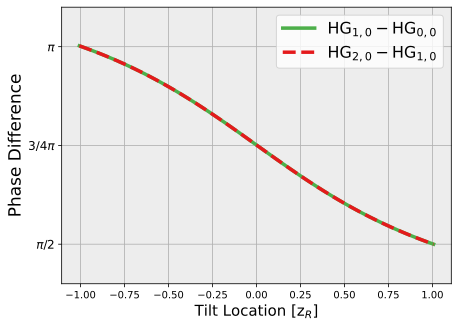

In [10]:
fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(7, 5))
background_color = '#ededed'
ax1.patch.set_facecolor(background_color)

ax1.plot(L_vals_plot, wrap(np.unwrap(phase1s)), lw=3.5, color=CB_color_cycle[2], label="HG$_{1,0} - $HG$_{0,0}$")
ax1.plot(L_vals_plot, wrap(np.unwrap(phase2s)), lw=3.5, color=CB_color_cycle[7], ls="--", label="HG$_{2,0} - $HG$_{1,0}$")

ax1.set_xlabel('Tilt Location [z$_{R}$]', fontsize=15)
ax1.set_ylabel('Phase Difference', fontsize=17)
ax1.grid()

ax1.set_yticks([1/2, 3/4, 1,])
ax1.set_yticklabels(["$\pi/2$", "$3/4\pi$", "$\pi$",], fontsize=12);
ax1.set_ylim([1/2-0.1, 1+0.1]);
legend = ax1.legend(fontsize=16, ncols=1, loc="best");

In [1]:
# Only terms that are mode dependant only depends on the transverse coordinates
# simply sum over the HG10 coefficients, no need for extra Gouy phase, as it is part of the HG10 mode basis

$$
\mathcal{U}_{n}^{\text {tilt }}(x, z) = \mathcal{U}_{n}(x, z) \cdot e^{ik\alpha x}=\mathcal{U}_{n}(x, z)+i \frac{\alpha}{\Theta}\left(\sqrt{n+1} \mathcal{U}_{n+1}(x, z) e^{-i \Psi}+\sqrt{n} \mathcal{U}_{n-1}(x, z) e^{i \Psi}\right),
$$
$$
\text{The special case } \mathrm{HG_{0,0}} \text{ mode:}\,\,\, \mathcal{U}_{0}^{\text {tilt }}(x, z) = \mathcal{U}_{0}(x, z) \cdot e^{ik\alpha x}=\mathcal{U}_{0}(x, z)+i \frac{\alpha}{\Theta} e^{-i \Psi}\cdot \mathcal{U}_{1}(x, z), \,\,\, \mathrm{HG_{1,0}} \text{ mode coefficient = } i \frac{\alpha}{\Theta} e^{-i \Psi}
$$

$$
\text{HG Mode Basis:} \,\,\, \mathcal{U}_{0}(x, z) \sim e^{i \Psi(z)} \text{,}\,\, \mathcal{U}_{1}(x, z) \sim e^{i 2\Psi(z)} 
$$

In [32]:
# IFrame(src='./illustration_EOBD.pdf', width=880, height=330)

### Check if `HGMode` considers the Gouy phase

In [237]:
w0 = 5.825e-05
zR0 = np.pi*w0**2/(1064e-9)
phases_HG10 = []
phases_HG00 = []
x0 = w0
y0 = w0
z_eval = np.linspace(-1, 1, 100)
for z in z_eval:
    q_ = zR0*1j + z*zR0
    HG_10 = HGMode(q_, n=1, m=0)
    HG_00 = HGMode(q_, n=0, m=0)
    HG_10_data = HG_10.unm(x0, y0)
    HG_00_data = HG_00.unm(x0, y0)
    HG_00_0 = HG_00.unm(0, 0)
    phase = np.angle(HG_10_data) - np.angle(HG_00_data)
    phases_HG10.append(phase[0][0])
    phases_HG00.append(np.angle(HG_00_0)[0][0])

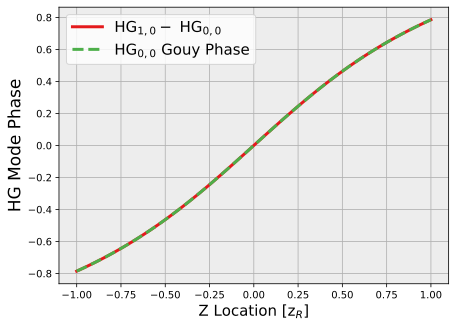

In [246]:
fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(7, 5))
background_color = '#ededed'
ax1.patch.set_facecolor(background_color)

ax1.plot(z_eval, np.unwrap(phases_HG10), label="HG$_{1,0}-$ HG$_{0,0}$", lw=3, color=CB_color_cycle[7],)
ax1.plot(z_eval, np.unwrap(phases_HG00), label="HG$_{0,0}$ Gouy Phase", ls='--', lw=3, color=CB_color_cycle[2],)

ax1.set_xlabel('Z Location [z$_{R}$]', fontsize=15)
ax1.set_ylabel(r'HG Mode Phase', fontsize=17)
ax1.grid()
legend = ax1.legend(fontsize=15, ncols=1, loc="best");